# Imports

In [28]:
# Data Wrangling and Loading
import pandas as pd
import numpy as np
import sqlite3

# Common 
import os
from pathlib import Path

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Modeling
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier

In [52]:
sns.set()

# Read Data

Megafon data stored in SQLite DataBase. Read cleaned version.

In [31]:
db_url = os.environ["DATABASE_URL"] 
with sqlite3.connect(f'../{db_url}') as conn:
    query = 'SELECT * FROM megafon_processed'
    df = pd.read_sql(query, conn)

print(df.info(verbose=False))
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Columns: 52 entries, X_1 to conversion
dtypes: float64(50), int64(2)
memory usage: 238.0 MB
None


,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,treatment_group,conversion
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,...,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,0,0
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,...,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,0,0
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,...,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,1,0
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,...,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,1,0
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,...,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,1,0


Split columns to different categories:
1. Features;
2. Target;
3. Treatment.

In [37]:
target = 'conversion'
treatment = 'treatment_group'
not_features = [target, treatment]
features = df.columns.difference(not_features).to_list()

# Sort features because sqlite returns columns at random order
features = sorted(features, key=lambda x: int(x.lstrip('X_')))

assert len(not_features + features) == len(df.columns), 'sanity check'

Lets look at datatype of features.

In [38]:
mapper = {**dict.fromkeys(features, 'feature'), **dict.fromkeys(not_features, 'not_feature')}
feature_dtypes = df.dtypes
feature_dtypes.index = feature_dtypes.index.map(mapper)
feature_dtypes = feature_dtypes.reset_index().set_axis(['attrubute_type', 'data_type'], axis=1)
feature_dtypes.value_counts()

attrubute_type  data_type
feature         float64      50
not_feature     int64         2
dtype: int64

There are only numerical features in dataset that are anonymised, probably using method like PCA.

# Exploratory Data Analysis

Goals:

1. Explore relationship between target and treatment features;
2. Explore features (descriptive statistics, relationship);
3. Explore dependencies between target and features (correlations and etc).

## Target and Treatment features Analysis

### Target share for Treatment/Control groups.

In [27]:
normalize_opt = [False, 'all', 'columns', 'index']
freq_tables = [
    pd.crosstab(df[target], df[treatment], margins=True, normalize=opt).round(2)
    for opt in normalize_opt
    ]

display(*freq_tables)

treatment_group,0,1,All
conversion,,,
0,245878,231608,477486
1,53754,68760,122514
All,299632,300368,600000


treatment_group,0,1,All
conversion,,,
0,0.41,0.39,0.8
1,0.09,0.11,0.2
All,0.50,0.50,1.0


treatment_group,0,1,All
conversion,,,
0,0.82,0.77,0.8
1,0.18,0.23,0.2


treatment_group,0,1
conversion,,
0,0.51,0.49
1,0.44,0.56
All,0.50,0.50


- There are target class imbalance;
- Treatment and Control group sizes are same.

### Conditional Independence Assumption

Lets check that treatment and control group splitted at random using Adversal Validation method.

In [30]:
cv_scores = cross_val_score(
    ExtraTreesClassifier(n_estimators=20, n_jobs=-1, random_state=2022), 
    df[features], df[treatment], 
    scoring='roc_auc', cv=3
    )

cv_scores = cv_scores.mean()
print(f'Adversal Validaton Roc Auc: {cv_scores:.2%}')

Adversal Validaton Roc Auc: 50.04%


Based on features classifier cannot distinguish between treatment and control groups. That means that communication was carried out by random.

## Feature Analysis

### Check for null values

In [ ]:
null_values_freq = (
    df[features].isna().sum().to_frame('num_null')
    .assign(perc_null=lambda x: x['num_null']/len(df))
    .mean()
)

null_values_freq

num_null     0.0
perc_null    0.0
dtype: float64

Dataset contains no null values.

### Descriptive statistics

In [69]:
descriptive_stats = df[features].describe()

plot_df = descriptive_stats.T.drop(columns=['count'])
plot_df.index = plot_df.index.str.lstrip('X_').astype('int')
plot_df = plot_df.reset_index().rename(columns={'index': '# feature'})
plot_df = plot_df.melt(id_vars=['# feature'])

In [80]:
plot_df['sign'] = (
    plot_df['value']
    .mask(plot_df['value'].gt(0), 'Positive')
    .mask(plot_df['value'].eq(0), 'Zero')
    .mask(plot_df['value'].lt(0), 'Negative')
)

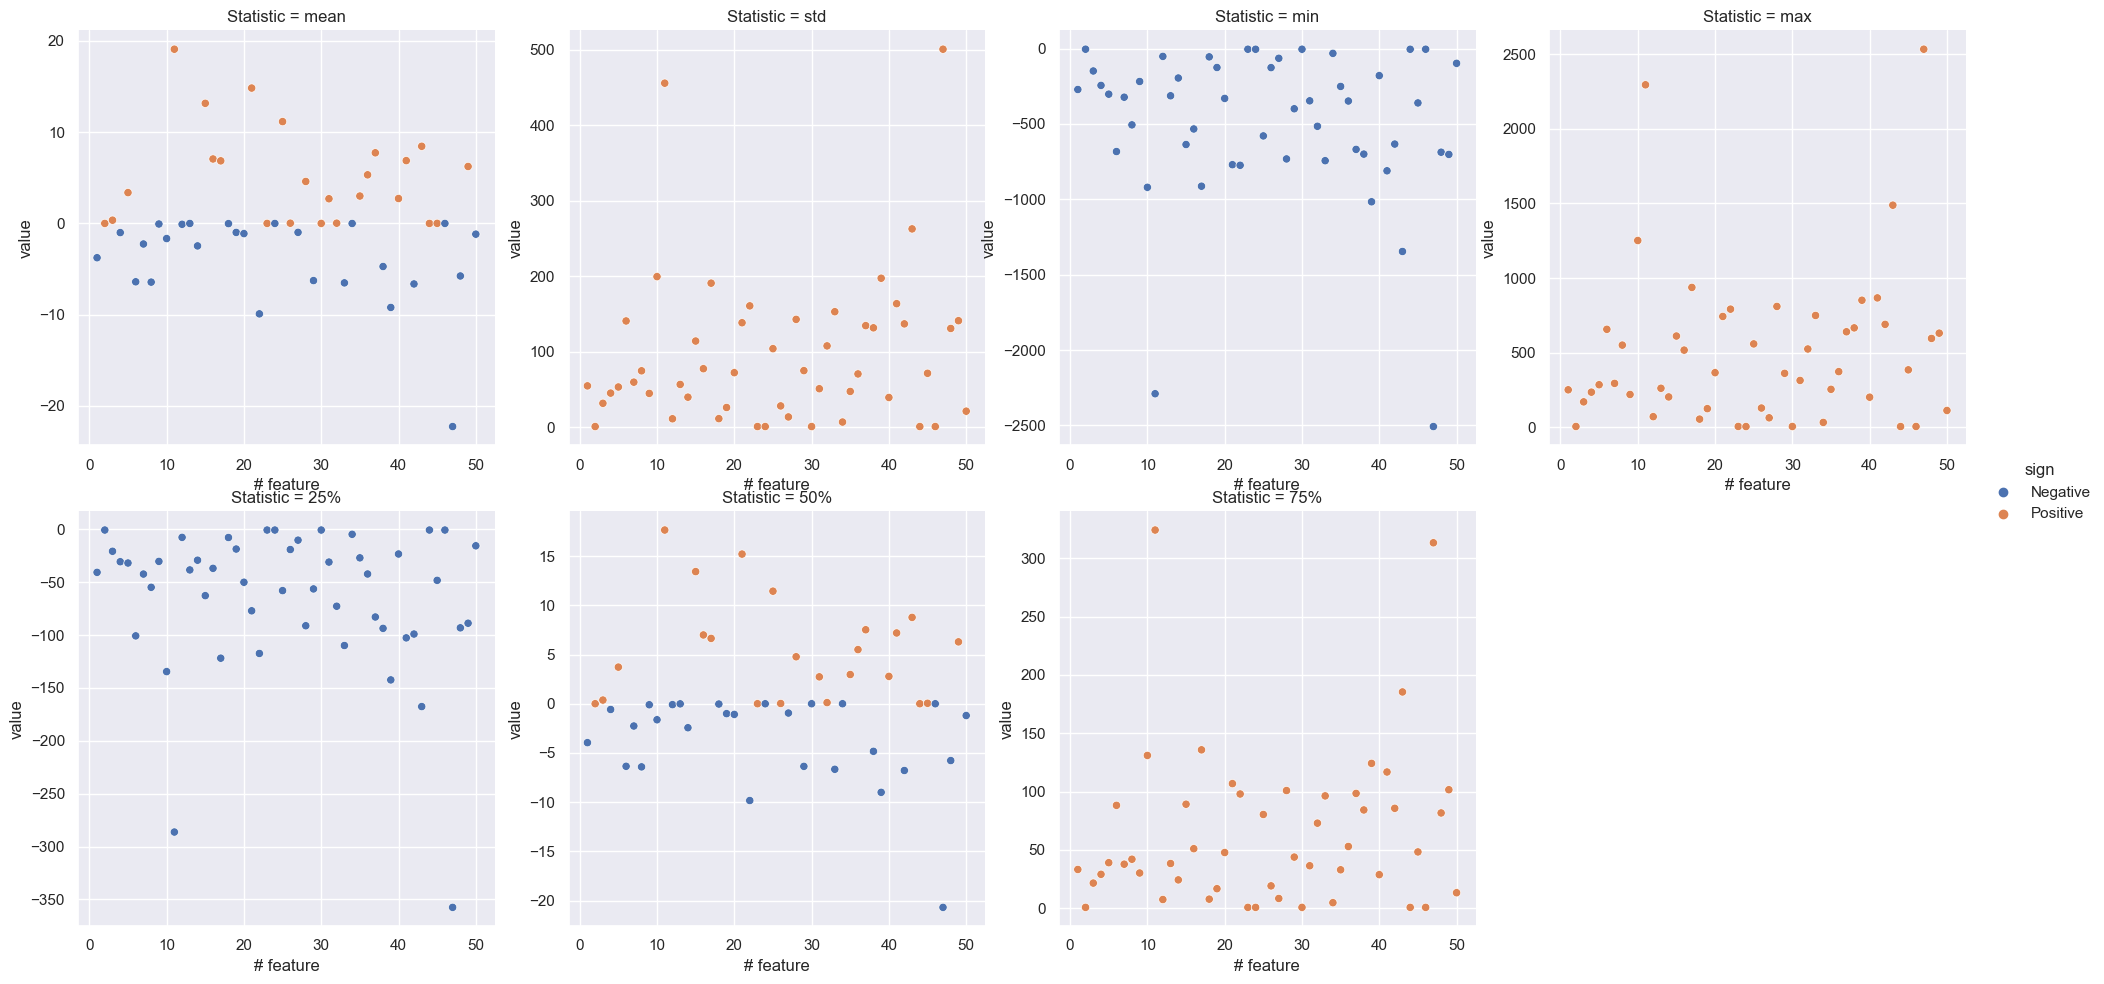

In [82]:
col_order = ['mean', 'std', 'min', 'max', '25%', '50%', '75%']
facet = sns.relplot(
    data=plot_df, x='# feature', y='value', hue='sign', 
    col='variable', col_wrap=4, col_order=col_order, 
    facet_kws={'sharey': False, 'sharex': False}
    )

facet.set_titles('Statistic = {col_name}');

# Validation Schema

In [60]:
df[treatment] = df[treatment].eq('treatment').astype('int')

In [61]:
train_idx, test_idx = train_test_split(df.index, test_size=0.2, stratify=df[[target, treatment]], random_state=2022)

X_train, y_train, treatment_train = df.loc[train_idx, features], df.loc[train_idx, target], df.loc[train_idx, treatment] 
X_test, y_test, treatment_test = df.loc[test_idx, features], df.loc[test_idx, target], df.loc[test_idx, treatment]

# Modeling

In [62]:
rf_model = RandomForestClassifier(max_depth=8, min_samples_leaf=124, random_state=2022)
ct_model = ClassTransformation(rf_model)

In [63]:
ct_model.fit(X_train, y_train, treatment_train)

ClassTransformation(estimator=RandomForestClassifier(max_depth=8,
                                                     min_samples_leaf=124,
                                                     random_state=2022))

# Evaluation

In [99]:
y_uplift_pred = ct_model.predict(X_test)

uplift_table = uplift_by_percentile(y_test, y_uplift_pred, treatment_test, bins=10, total=True)
uplift_table

/Users/alexwest/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,6081,5919,0.416708,0.162190,0.254518
10-20,5960,6040,0.285906,0.163576,0.122330
20-30,5993,6007,0.282997,0.174963,0.108034
30-40,6048,5952,0.279101,0.164147,0.114954
40-50,5957,6043,0.257009,0.154063,0.102946
50-60,6042,5958,0.208540,0.150386,0.058154
60-70,5944,6056,0.180855,0.163970,0.016885
70-80,6018,5982,0.183283,0.204948,-0.021665
80-90,5999,6001,0.129188,0.238460,-0.109272


In [83]:
quantiles = pd.qcut(y_uplift_pred, 10)
y_pred_df = pd.concat([y_test.to_frame(), treatment_test.to_frame()], axis=1)
y_pred_df['quantiles'] = quantiles

In [92]:
y_pred_df.pivot_table(index='quantiles', columns='treatment_group', values='conversion')

treatment_group,0,1
quantiles,,
"(-0.229, -0.0121]",0.217493,0.063992
"(-0.0121, 0.0288]",0.238460,0.129188
"(0.0288, 0.0378]",0.204948,0.183283
"(0.0378, 0.0416]",0.163970,0.180855
"(0.0416, 0.046]",0.150386,0.208540
"(0.046, 0.0535]",0.154063,0.257009
"(0.0535, 0.0657]",0.164147,0.279101
"(0.0657, 0.0797]",0.174963,0.282997
"(0.0797, 0.0977]",0.163576,0.285906


In [98]:
np.quantile(y_uplift_pred, 0.1)

-0.012146129649857248